## 20250129 : GAN Generative Adversarial Network


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


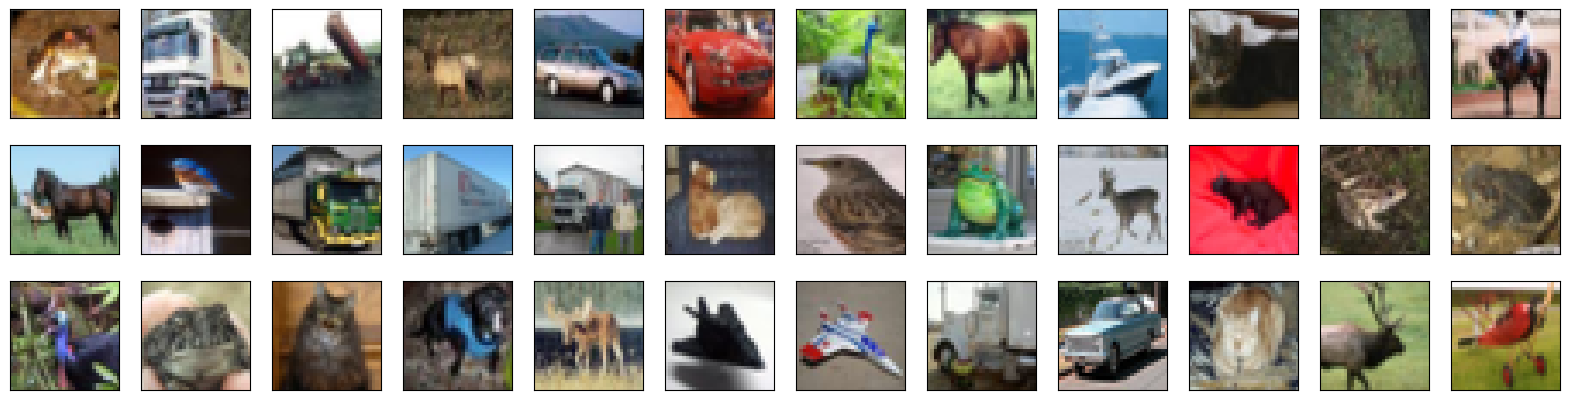

In [1]:
from keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt
(train_x,train_y),(test_x,test_y) = load_data()
fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(train_x[i])

In [2]:
train_x.shape

(50000, 32, 32, 3)

In [3]:
# Creating Model :
# Con2D => DOwnsize 32x32 to 4x4 and
# Conv2DTranspose => Upscale new generated images from 4x4 => 32x32

In [4]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Conv2DTranspose,Flatten,Dropout,Reshape
from keras.layers import BatchNormalization,LeakyReLU
from keras.optimizers import Adam
import numpy as np

def my_discriminator(in_shape=(32,32,3)):
  #Define Model
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3,3), padding="same", input_shape=in_shape))
    model.add(LeakyReLU(0.2))

  # downsample
    model.add(Conv2D(128, kernel_size=(3,3), strides=(2,2), padding="same"))
    model.add(LeakyReLU(0.2))

   # downsample
    model.add(Conv2D(128, kernel_size=(3,3), strides=(2,2), padding="same"))
    model.add(LeakyReLU(0.2))

 # downsample
    model.add(Conv2D(256, kernel_size=(3,3), strides=(2,2), padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

 # Compile Model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [5]:
mymodel = my_discriminator()
mymodel.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 522,497 (1.99 MB)

 Trainable params: 522,497 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
#convert all the pixel in -1 to 1 range
def load_real_samples():
  (train_x,_),(_,_) = load_data()
  images = train_x.astype('float32')
  # scale from [0,255] to [-1,1]
  images = (images - 127.5) / 127.5
  return images

In [7]:
# Generate n real samples with class label 1
def generate_real_samples(dataset,n_samples):
  ix = np.random.randint(0,dataset.shape[0],n_samples)
  X = dataset[ix]
  y = np.ones((n_samples,1))
  return X,y

In [8]:
# generate n fake sampes with class label 0
def generate_fake_samples(n_samples):
  #uniform random numbers [0,1]
  x = np.random.rand(32*32*3*n_samples)
  #making in range of -1 to 1
  x = -1 + x*2
  #reshape in batch of color images
  x = x.reshape(n_samples,32,32,3)
  # genrating fake labels(0)
  y = np.zeros((n_samples,1))
  return x,y

In [9]:
samples_real,labels_real = generate_real_samples(train_x,64)

In [10]:
samples_real.shape


(64, 32, 32, 3)

In [11]:
samples_real

array([[[[ 60,  60,  43],
         [ 60,  59,  45],
         [ 47,  45,  34],
         ...,
         [ 53,  58,  53],
         [ 31,  35,  35],
         [ 12,  17,  12]],

        [[155, 166, 144],
         [158, 168, 149],
         [135, 145, 129],
         ...,
         [ 12,  16,  10],
         [  9,  16,   6],
         [  9,  19,   7]],

        [[201, 210, 191],
         [191, 200, 182],
         [180, 189, 172],
         ...,
         [ 95, 101,  88],
         [ 95, 104,  85],
         [ 93, 106,  84]],

        ...,

        [[207, 215, 180],
         [213, 213, 177],
         [212, 211, 172],
         ...,
         [217, 224, 201],
         [211, 219, 194],
         [217, 223, 199]],

        [[214, 223, 191],
         [222, 223, 191],
         [226, 226, 193],
         ...,
         [220, 228, 205],
         [211, 221, 196],
         [215, 224, 200]],

        [[210, 219, 191],
         [221, 222, 196],
         [226, 227, 200],
         ...,
         [218, 228, 207],
        

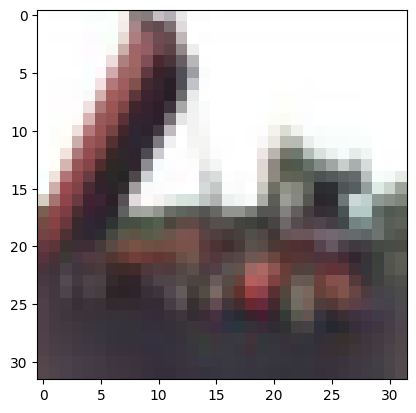

In [12]:
plt.imshow(samples_real[33])

In [13]:
def1 =generate_fake_samples(64)

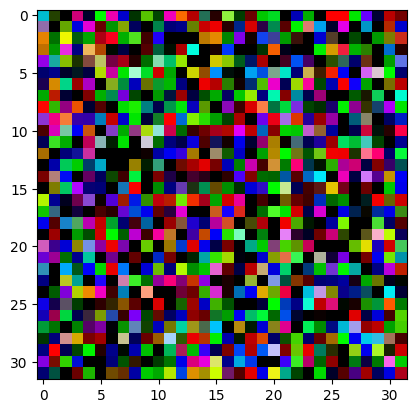

In [14]:
plt.imshow(def1[0][0])

In [15]:
def train_discriminator(mymodel,datset,n_iter=100,n_batch=128):
  half_batch = int(n_batch/2)
  # manually enumerate epochs
  for i in range(n_iter):
    # randomly selected real samples
    x_real,y_real = generate_real_samples(datset,half_batch)
    # training on those real samples
    _,real_acc = mymodel.train_on_batch(x_real,y_real)
    # randomly selected fake samples
    x_fake,y_fake = generate_fake_samples(half_batch)
    #training on those samples
    _,fake_acc = mymodel.train_on_batch(x_fake,y_fake)
    print("real data accuracy --> {} | Fake data accuracy --> {}".format(real_acc,fake_acc))


In [16]:
## Example training
mymodel = my_discriminator()
dataset = load_real_samples()
train_discriminator(mymodel,dataset)

real data accuracy --> 0.3125 | Fake data accuracy --> 0.15625


real data accuracy --> 0.4270833432674408 | Fake data accuracy --> 0.3515625


real data accuracy --> 0.46562498807907104 | Fake data accuracy --> 0.453125
real data accuracy --> 0.5178571343421936 | Fake data accuracy --> 0.537109375
real data accuracy --> 0.5833333134651184 | Fake data accuracy --> 0.6187499761581421
real data accuracy --> 0.6420454382896423 | Fake data accuracy --> 0.671875
real data accuracy --> 0.6899038553237915 | Fake data accuracy --> 0.7120535969734192
real data accuracy --> 0.7208333611488342 | Fake data accuracy --> 0.73828125
real data accuracy --> 0.75 | Fake data accuracy --> 0.7638888955116272
real data accuracy --> 0.7672697305679321 | Fake data accuracy --> 0.7789062261581421
real data accuracy --> 0.784970223903656 | Fake data accuracy --> 0.7947443127632141
real data accuracy --> 0.7995923757553101 | Fake data accuracy --> 0.8079426884651184
real data accuracy --> 0.8118749856948853 | Fake data accuracy --> 0.8191105723381042
real data accuracy --> 0.8246527910232544 | Fake data accuracy --> 0.8309151530265808
real data accurac

In [17]:
# latent_dim:Noise as vector of 100D.
def define_generator(latent_dim):
  model = Sequential()
  n_nodes = 256*4*4
  model.add(Dense(n_nodes,input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4,4,256)))
  # upsample to 8x8
  model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 16x16
  model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample of 32x32
  model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #output layer
  model.add(Conv2D(3,(3,3),activation='tanh',padding='same'))
  return model



In [18]:
latent_dim = 100
model = define_generator(latent_dim)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 4096)                │         413,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 3)           │           3,459 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,466,115 (5.59 MB)

 Trainable params: 1,466,115 (5.59 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# creating a noise
def generate_latent_points(latent_dim,n_samples):
   #generate points in the latent space
   x_input = np.random.randn(latent_dim*n_samples)
   # reshape into batch of inputs
   x_input = x_input.reshape(n_samples,latent_dim)
   return x_input

In [20]:
# generator to generate n fake samples, with class labels
def generate_fake_samples(g_model,latent_dim,n_samples):
  #generate points in latent space
  x_input = generate_latent_points(latent_dim,n_samples)
  # generate the output by prediction from generator
  X = g_model.predict(x_input)
  # create fake class label 0
  y = np.zeros((n_samples,1))
  return X,y

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


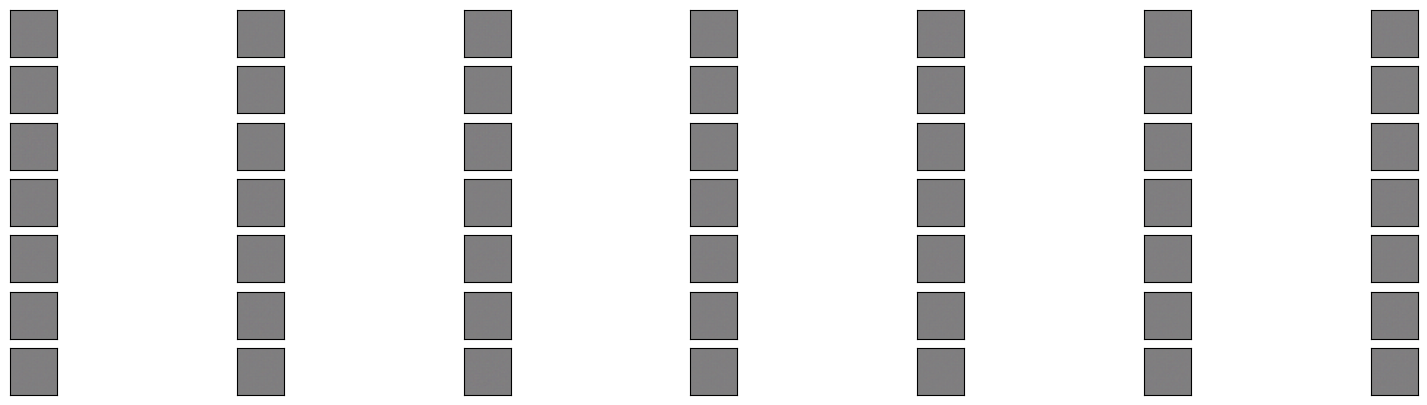

In [21]:
latent_dim = 100

model = define_generator(latent_dim)
n_samples=49
X,_ = generate_fake_samples(model,latent_dim,n_samples)
# scale pixel values from [-1,1] to [0,1]
X = (X+1)/2.0
# plot the generated samples
fig = plt.figure(figsize =(20,5))
for i in range(n_samples):
  ax = fig.add_subplot(7,7,i + 1, xticks=[], yticks=[])
  ax.imshow(X[i])


In [22]:
def define_gan(g_model,d_model):
  d_model.trainable = False
  model = Sequential()
  model.add(g_model)
  model.add(d_model)
  opt = Adam(learning_rate=0.0002,beta_1 = 0.5)
  model.compile(loss="binary_crossentropy",optimizer = opt)
  return model

In [23]:
laten_dim = 100
d_model = my_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model,d_model)
gan_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)            │ (None, 32, 32, 3)           │       1,466,115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 1)                   │         522,497 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,988,612 (7.59 MB)

 Trainable params: 1,466,115 (5.59 MB)

 Non-trainable params: 522,497 (1.99 MB)

In [24]:
def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=2,n_batch=128):
  batch_per_epo = int(dataset.shape[0]/n_batch)
  half_batch=int(n_batch/2)
  for i in range(n_epochs):
    for j in range(batch_per_epo):
      x_real,y_real = generate_real_samples(dataset,half_batch)
      d_loss_real,_ = d_model.train_on_batch(x_real,y_real)
      x_fake,y_fake = generate_fake_samples(g_model,latent_dim,half_batch)
      d_loss_fake,_ = d_model.train_on_batch(x_fake,y_fake)
      x_gan = generate_latent_points(latent_dim,n_batch)
      y_gan = np.ones((n_batch,1))
      g_loss = gan_model.train_on_batch(x_gan,y_gan)
      print(f"epoch {i} batch {j} of 390, d_loss real {d_loss_real}, d_loss_fake {d_loss_fake},gan loss {g_loss}")


In [25]:
# def save_plot(examples,epoch,n=7)
train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=1,n_batch=128)

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
epoch 0 batch 0 of 390, d_loss real 0.6968364715576172, d_loss_fake 0.6948188543319702,gan loss [array(0.69481885, dtype=float32), array(0.69481885, dtype=float32), array(0.5703125, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
epoch 0 batch 1 of 390, d_loss real 0.6959681510925293, d_loss_fake 0.6953845024108887,gan loss [array(0.6953845, dtype=float32), array(0.6953845, dtype=float32), array(0.38671875, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
epoch 0 batch 2 of 390, d_loss real 0.695416271686554, d_loss_fake 0.6953305602073669,gan loss [array(0.69533056, dtype=float32), array(0.69533056, dtype=float32), array(0.33072916, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
epoch 0 batch 3 of 390, d_loss real 0.695560872554779, d_loss_fake 0.6956644654273987,gan loss [array(0.69566447, dtype=float32), array(0.69566447, dtype=float32), array(0.30273438, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
epoch 0 batch 4 of

In [ ]:
# def save_plot(examples,epoch,n=7)
train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=2,n_batch=128)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
epoch 0 batch 0 of 390, d_loss real 0.9879748821258545, d_loss_fake 0.9885176420211792,gan loss [array(0.98851764, dtype=float32), array(0.98851764, dtype=float32), array(0.19031729, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
epoch 0 batch 1 of 390, d_loss real 0.9881526827812195, d_loss_fake 0.9887004494667053,gan loss [array(0.98870045, dtype=float32), array(0.98870045, dtype=float32), array(0.19019052, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
epoch 0 batch 2 of 390, d_loss real 0.9883331060409546, d_loss_fake 0.988878071308136,gan loss [array(0.9888781, dtype=float32), array(0.9888781, dtype=float32), array(0.19012405, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
epoch 0 batch 3 of 390, d_loss real 0.9885075688362122, d_loss_fake 0.9890391826629639,gan loss [array(0.9890392, dtype=float32), array(0.9890392, dtype=float32), array(0.19011739, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
epoch 0 batch 4 of 

In [ ]:
# Generate 100 samples for testing
latent_points = generate_latent_points(latent_dim, 100)
generated_images = g_model.predict(latent_points)

# Example: Save generated images for inspection
for i, img in enumerate(generated_images[:10]):
    plt.imsave(f"generated_image_{i}.png", img[:, :, 0], cmap="gray")
